In [165]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re

In [166]:
# Preprocess

# Check out each file. Content, images

root_path = "../input/indoor-location-navigation/"
train_paths = glob.glob(root_path + "train" + "/*/*/*")
test_paths = glob.glob(root_path + "test" + "/*")
metafiles = glob.glob(root_path + "metadata" + "/*")

print("No. Files in Train: {:,}".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,}".format(len(test_paths)), "\n" +
      "No. of metadata files: {:,}".format(len(metafiles)))

# Reading in 1 file
def pick_example(max_range, paths):
    ex = random.randint(0, max_range)
    example_path = paths[ex]
    path = f"{example_path}"
    paths = path.split("/")
    site = paths[4]
    floorNo = paths[5]
    floor_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_image.png"
    json_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    return path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter

path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
print("example path: ", path)
print("site: ", site)
print("floorNo: ", floorNo)
print("floor_plan_filename: ", floor_plan_filename)
print("json_plan_filename: ", json_plan_filename)
print("width: {}, height: {} ".format(width_meter, height_meter))

with open(path) as p:
    lines = p.readlines()
print("No. Lines in 1 example: {:,}". format(len(lines)))

No. Files in Train: 26,925 
No. Files in Test: 626 
No. of metadata files: 204
example path:  ../input/indoor-location-navigation/train/5cd969f339e2fc0b4afebbd0/F1/5d09f3701a9498000952a0d8.txt
site:  5cd969f339e2fc0b4afebbd0
floorNo:  F1
floor_plan_filename:  ../input/indoor-location-navigation/metadata/5cd969f339e2fc0b4afebbd0/F1/floor_image.png
json_plan_filename:  ../input/indoor-location-navigation/metadata/5cd969f339e2fc0b4afebbd0/F1/floor_info.json
width: 142.44176168273864, height: 119.44584076615571 
No. Lines in 1 example: 146,274


In [167]:
for line in lines[:200]:
    print(line)

#	startTime:1560932641592

#	SiteID:5cd969f339e2fc0b4afebbd0	SiteName:沃尔玛购物广场(南浦大桥店)	FloorId:5cd969f639e2fc0b4afebef1	FloorName:F1

#	Brand:HUAWEI	Model:VTR-AL00	AndroidName:8.0.0	APILevel:26	

#	type:1	name:accelerometer-icm20690	version:1	vendor:invensense	resolution:0.009576807	power:0.23	maximumRange:78.4532

#	type:4	name:gyroscope-icm20690	version:1	vendor:invensense	resolution:1.7453292E-5	power:6.1	maximumRange:34.906586

#	type:2	name:mag-akm09911	version:1001	vendor:akm	resolution:0.0625	power:6.8	maximumRange:2000.0

#	VersionName:v20190612-nightly	VersionCode:263	

1560932641593	TYPE_WAYPOINT	105.12363	28.899364

1560932641788	TYPE_ACCELEROMETER	-0.6895301	1.6089035	9.758766

1560932641788	TYPE_MAGNETIC_FIELD	38.3125	10.8125	-0.5625

1560932641788	TYPE_GYROSCOPE	-0.020228365	-0.015969763	-0.029810224

1560932641788	TYPE_ROTATION_VECTOR	0.051999	0.081546	0.599729

1560932641788	TYPE_MAGNETIC_FIELD_UNCALIBRATED	-346.0	1139.9375	240.6875

1560932641788	TYPE_GYROSCOPE_UNCALIBRA

In [168]:
# using github repo in kaggle kernels
# https://www.kaggle.com/getting-started/71642
!cp -r ../input/indoorlocationcompetition20master/indoor-location-competition-20-master/* ./

In [169]:
# Import custom function from the repository
from io_f import read_data_file

# Read in 1 random example
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
sample_file = read_data_file(path)

# You can access the information for each variable:
# Each data is split for time
# Metadata is expressed with "#"

# for i in sample_file.acce[:, [0]]:
#     print(i)
#     print(int(i))

# print("~~~ Example ~~~")
# print("acce: {}".format(sample_file.acce), "\n" +
#       "acce shape: {}".format(sample_file.acce.shape), "\n" +
#       "acacce_uncalice: {}".format(sample_file.acce_uncali), "\n" +
#       "acacce_uncalice shape: {}".format(sample_file.acce_uncali.shape), "\n" +
#       "ahrs: {}".format(sample_file.ahrs), "\n" +
#       "ahrs shape: {}".format(sample_file.ahrs.shape), "\n" +
#       "gyro: {}".format(sample_file.gyro), "\n" +
#       "gyro shape: {}".format(sample_file.gyro.shape), "\n" +
#       "gyro_uncali: {}".format(sample_file.gyro_uncali), "\n" +
#       "gyro_uncali shape: {}".format(sample_file.gyro_uncali.shape), "\n" +
#       "ibeacon: {}".format(sample_file.ibeacon), "\n" +
#       "ibeacon shape: {}".format(sample_file.ibeacon.shape), "\n" +
#       "magn: {}".format(sample_file.magn), "\n" +
#       "magn shape: {}".format(sample_file.magn.shape), "\n" +
#       "magn_uncali: {}".format(sample_file.magn_uncali), "\n" +
#       "magn_uncali shape: {}".format(sample_file.magn_uncali.shape), "\n" +
#       "waypoint: {}".format(sample_file.waypoint), "\n" +
#       "waypoint shape: {}".format(sample_file.waypoint.shape), "\n" +
#       "wifi: {}".format(sample_file.wifi), "\n" +
#       "wifi shape: {}".format(sample_file.wifi.shape))

In [170]:
def show_site_png(root_path, site):
    floor_paths = glob.glob(root_path + "metadata/" + site + "/*/floor_image.png")
    n = len(floor_paths)
    print("No. of floor paths: ", n)

    # Create the custom number of rows & columns
    ncols = [ceil(n / 3) if n > 4 else 4][0]
    nrows = [ceil(n / ncols) if n > 4 else 1][0]

    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Site no. '{site}'", fontsize=18)

    # Plot image for each floor
    for k, floor in enumerate(floor_paths):
        # plt.subplot(nrows, ncols, k+1)
        plt.subplot(ncols, nrows, k+1)
        plt.rcParams["figure.facecolor"] = "white"

        image = Image.open(floor)

        plt.imshow(image)
        plt.axis("off")
        title = floor.split("/")[5]
        plt.title(title, fontsize=15)

No. of floor paths:  8


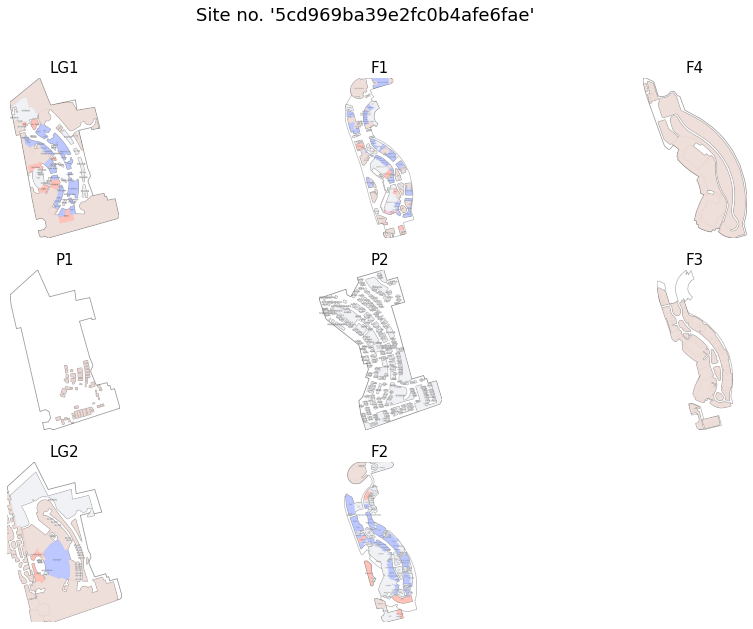

In [171]:
path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
show_site_png(root_path, site=site)

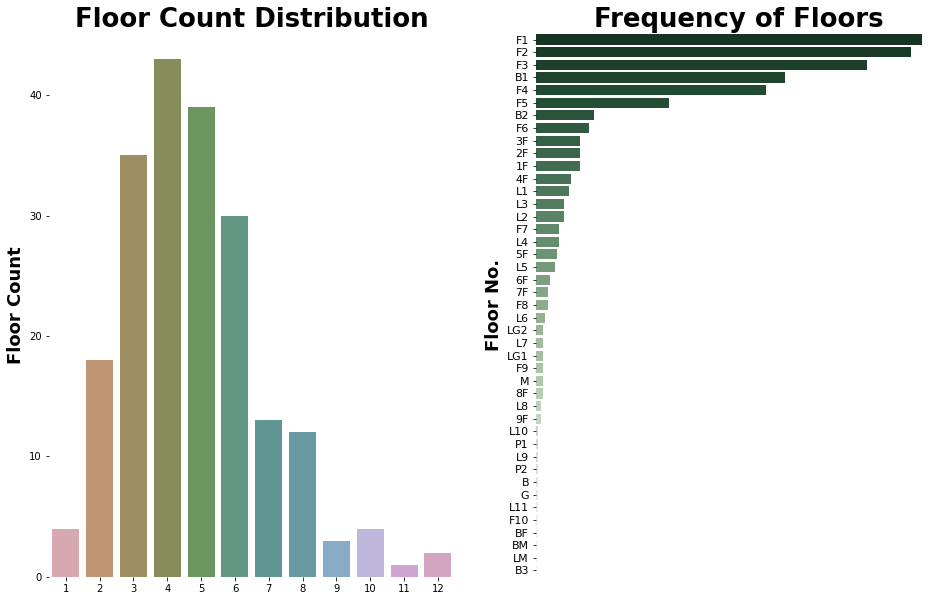

In [172]:
# Checking the floor number distribution

all_floors = glob.glob("../input/indoor-location-navigation/metadata/*/*")
all_sites = glob.glob("../input/indoor-location-navigation/metadata/*")
floor_no = []
floor_counts = []

# Floor count
for site in all_sites:
    floor_count = len([name for name in os.listdir(site)])
    floor_counts.append(floor_count)

floor_counts_df = pd.DataFrame(floor_counts, columns=["F_Count"])
floor_counts_df = floor_counts_df["F_Count"].value_counts().reset_index()
floor_counts_df = floor_counts_df.sort_values("index", ascending=True)

# Extract only the floor number
for floor in all_floors:
    no = floor.split("/")[5]
    floor_no.append(no)
    
floor_no = pd.DataFrame(floor_no, columns=["No"])
floor_no = floor_no["No"].value_counts().reset_index()
floor_no = floor_no.sort_values("No", ascending=False)

# ToDo: Floor expressions need to be fixed
# 1F -> F1, L1 -> F1, G -> F1 etc

# Plot
# display(floor_counts_df.head(10))

fig, axes = plt.subplots(ncols=2, figsize=(16, 10))
axes[0] = sns.barplot(data=floor_counts_df, x="index", y="F_Count", saturation=0.4, ax=axes[0])
axes[0].set_title("Floor Count Distribution", size = 26, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Floor Count", size = 18, weight="bold")

axes[1] = sns.barplot(data=floor_no, x="No", y="index", palette="Greens_r", saturation=0.4, ax=axes[1])
axes[1].set_title("Frequency of Floors", size = 26, weight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("Floor No.", size = 18, weight="bold")

plt.xticks([])
plt.yticks(fontsize=11)
sns.despine(left=True, bottom=True);

No. of geojson file: 981
File path: ../input/indoor-location-navigation/metadata/5cd56b5ae2acfd2d33b58546/F2/geojson_map.json
SiteID: 5cd56b5ae2acfd2d33b58546
Floor: F2
Floor info: {'Vr': '000200', 'category': 'floor', 'name': 'F2', 'code': 'TY0010300110200004', 'floor_num': 2, 'type': 'floor'}


'floor_num_df length: 981'

site_id floor_no  floor_no_json
0  5cd56c0ce2acfd2d33b6ab27       B1           -1.0
1  5cd56c0ce2acfd2d33b6ab27       F3            3.0
2  5cd56c0ce2acfd2d33b6ab27       F2            2.0
3  5cdbc652853bc856e89a8694       B1           -1.0
4  5cdbc652853bc856e89a8694       F1            1.0

<Figure size 432x288 with 0 Axes>

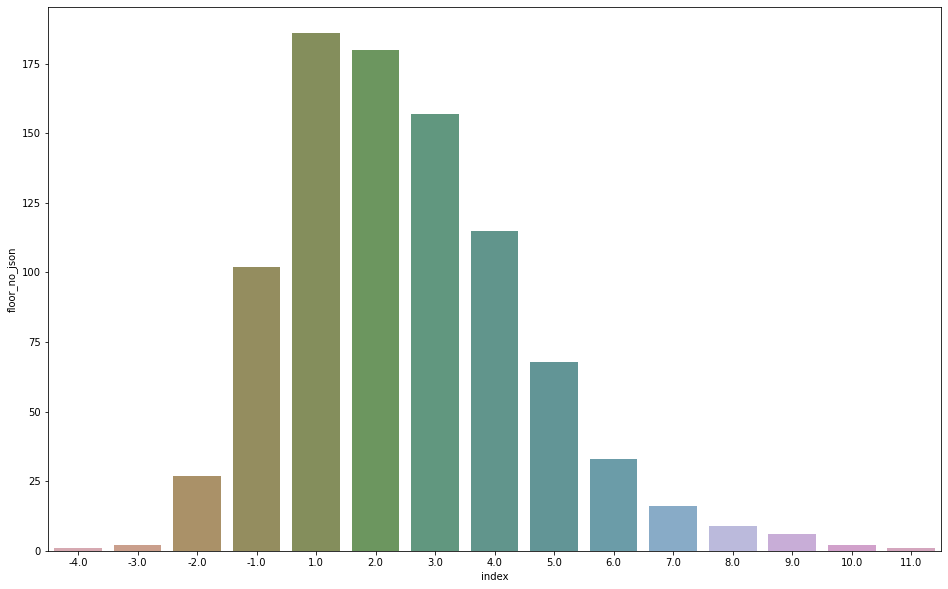

In [173]:
# Metadata checking (GeoJSON)
# This is a vector representation of floor map
geojson_paths = glob.glob("../input/indoor-location-navigation/metadata/*/*/geojson_map.json")
print("No. of geojson file: {}".format(len(geojson_paths)))

# Print one example
ex = random.randint(0, len(geojson_paths))
geojson_file_name = geojson_paths[ex]
with open(geojson_file_name) as json_file:
    paths = geojson_file_name.split("/")
    site_id = paths[4]
    floor = paths[5]
    json_data = json.load(json_file)
    json_properties = json_data["features"][0]["properties"]
    print("File path: {}".format(geojson_file_name))
    print("SiteID: {}".format(site_id))
    print("Floor: {}".format(floor))
    print("Floor info: {}".format(json_properties))

# create id and floor number matching file
site_ids = []
floor_no = []
floor_no_json = []

for i in range(0, len(geojson_paths)):
    with open(geojson_paths[i]) as f:
        paths = geojson_paths[i].split("/")
        site_id = paths[4]
        floor = paths[5]
        site_ids.append(site_id)
        floor_no.append(floor)
        d = json.load(f)
        try:
            floor_no_json.append(d["features"][0]["properties"]["floor_num"])
        except:
            floor_no_json.append(np.nan)

floor_num_df = pd.DataFrame(
    {"site_id": site_ids,
     "floor_no": floor_no,
     "floor_no_json": floor_no_json,
    })

display("floor_num_df length: {}".format(len(floor_num_df)))
display(floor_num_df.head())

# Get floormap dict to be used later
floor_map_pairs = list(zip(floor_num_df["floor_no"], floor_num_df["floor_no_json"]))
floor_map_pairs = np.unique(floor_map_pairs, axis=0) # get unique pair
# print(floor_map_pairs) # to be used as floor_map later

# Plot distribution
floor_num_count_df = floor_num_df["floor_no_json"].value_counts().reset_index()
floor_num_count_df = floor_num_count_df.sort_values("floor_no_json", ascending=False)
# display(floor_num_count_df)
# print(len(floor_num_count_df["floor_no_json"] == np.nan))

fig = plt.figure()
ax = plt.subplots(figsize=(16, 10))
sns.barplot(data=floor_num_count_df, x="index", y="floor_no_json", saturation=0.4)
fig.show()

# Just in case: Need for altitude info in geoJSON
# from pyproj import Proj, transform
# print(transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -0.1285907, 51.50809))  # longitude first, latitude second.
# output (meters east of 0, meters north of 0): (-14314.651244750548, 6711665.883938471)

Processing ../input/indoor-location-navigation/train/5cd56b6ae2acfd2d33b59ccb/F3/5d04aff0db9d6500083245ff.txt...
Waypoints: [[1.56058780e+12 1.06121796e+02 1.26702545e+02]
 [1.56058781e+12 1.10611000e+02 1.21006940e+02]
 [1.56058781e+12 1.13863150e+02 1.11513630e+02]
 [1.56058782e+12 1.09067460e+02 1.04353390e+02]]



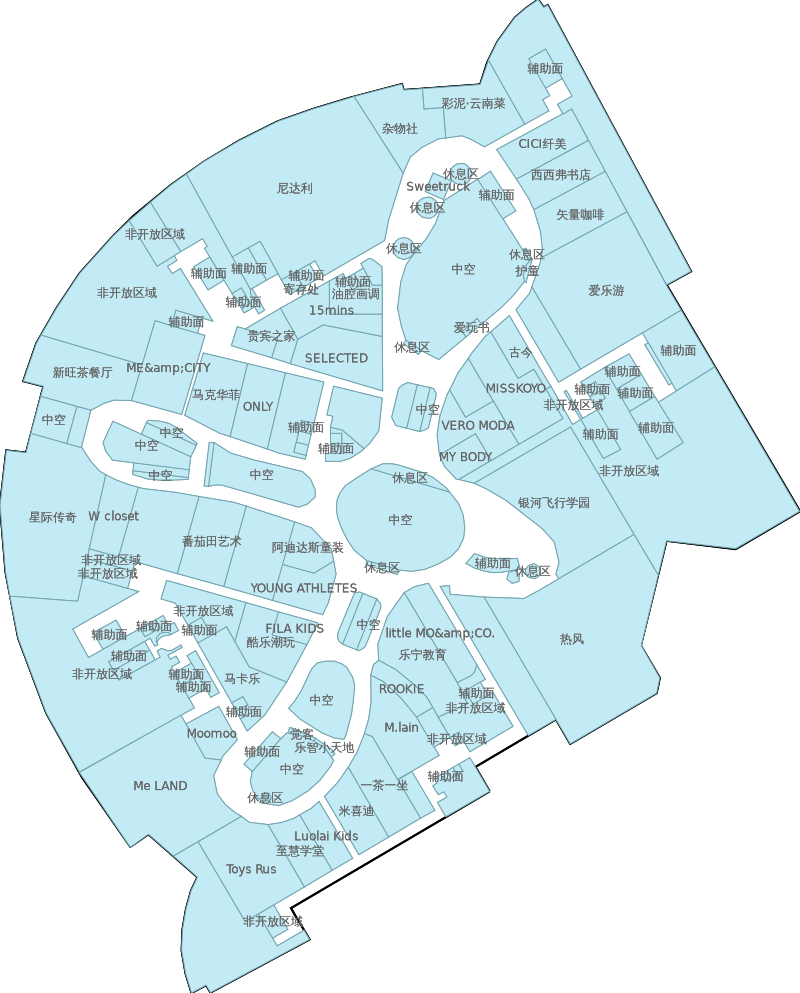

In [174]:
# More viz on accelerometers, wifi etc in one go
from visualize_f import visualize_trajectory, visualize_heatmap
from main import extract_wifi_rssi, extract_wifi_count
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from main import extract_ibeacon_rssi

# Visualizing magnetic strength
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# extract mag, wifi, beacon of one example
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position([path])
magnetic_strength = extract_magnetic_strength(mwi_datas)
wifi_rssi = extract_wifi_rssi(mwi_datas)
wifi_counts = extract_wifi_count(mwi_datas)
ibeacon_rssi = extract_ibeacon_rssi(mwi_datas)
ibeacon_ummids = list(ibeacon_rssi.keys())
target_ibeacon = ibeacon_ummids[0]

# positions for heatmap
heat_positions = np.array(list(magnetic_strength.keys()))
heat_values = np.array(list(magnetic_strength.values()))
heat_positions_wifi = np.array(list(wifi_counts.keys()))
heat_values_wifi = np.array(list(wifi_counts.values()))
heat_positions_bc = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
heat_values_bc = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:, 0]

# filter out positions that no wifi detected
mask = heat_values_wifi != 0
heat_positions_wifi = heat_positions_wifi[mask]
heat_values_wifi = heat_values_wifi[mask]

# get trajectory
example = read_data_file(path)
trajectory = example.waypoint # Returns timestamp, x, y values
print(f"Waypoints: {trajectory}")
trajectory = trajectory[:, 1:3] # Removes timestamp (we only need the coordinates)

# Plot trajectory
visualize_trajectory(trajectory = trajectory,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = "Example of Waypoint",)


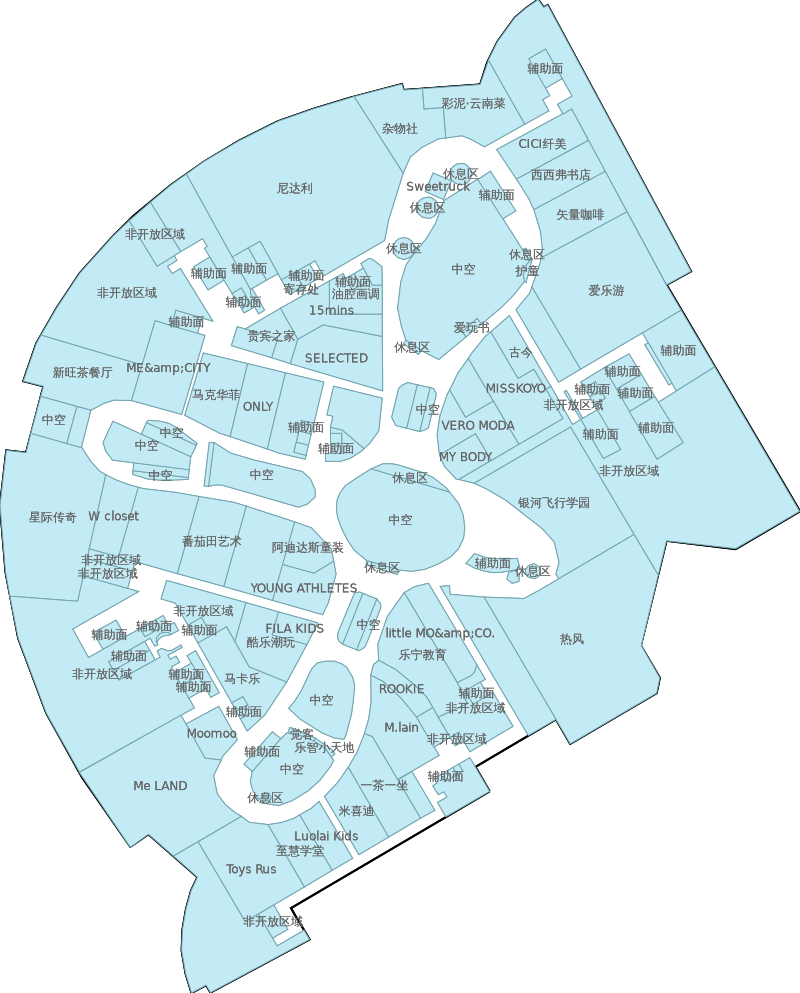

In [175]:
# plot magnnetic strength
visualize_heatmap(heat_positions,
                  heat_values,
                  floor_plan_filename,
                  width_meter, 
                  height_meter, 
                  colorbar_title='mu tesla', 
                  title='Magnetic Strength')

This floor has 252 wifi aps (access points).



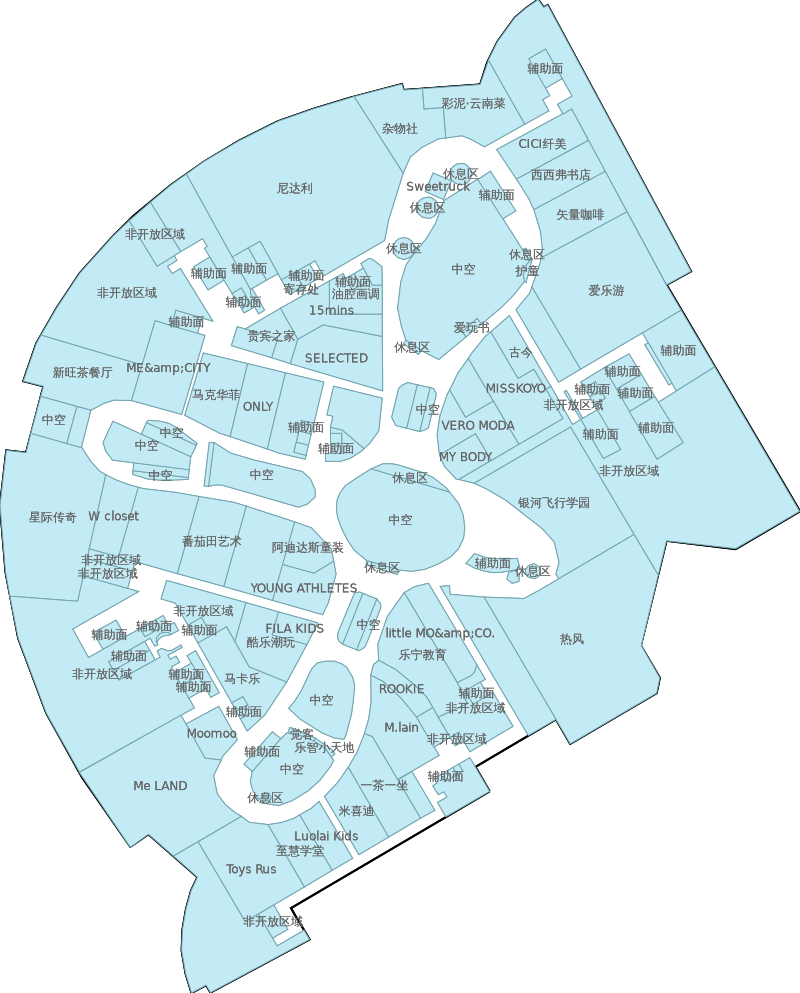

In [176]:
# WiFi data
print(f'This floor has {len(wifi_rssi.keys())} wifi aps (access points).')
visualize_heatmap(heat_positions_wifi, 
                  heat_values_wifi, 
                  floor_plan_filename, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='count', 
                  title=f'WiFi Count')

This floor has 11 ibeacons.



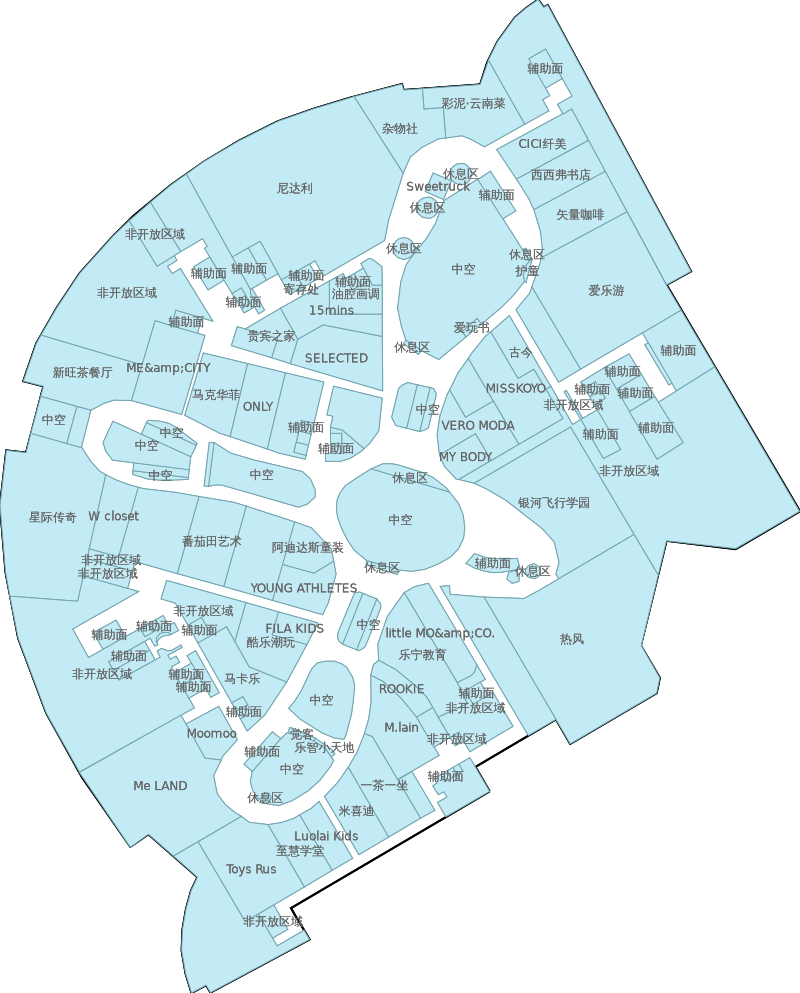

In [177]:
# The heatmap
print(f'This floor has {len(ibeacon_rssi.keys())} ibeacons.')
visualize_heatmap(heat_positions_bc,
                  heat_values_bc,
                  floor_plan_filename,
                  width_meter,
                  height_meter,
                  colorbar_title='dBm',
                  title='iBeacon RSSE')

In [178]:
# Try working out step_positions for 1 trace file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

path_datas = read_data_file(path)
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint # not to be used

# Feature candidate
# You can't get the waypoint in test, so use acce and ahrs data to calculate relative positions
def calc_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    # only use del if we don't need timestamps
    # rel_positions_del = np.delete(rel_positions, 0, 1)
    return rel_positions

rel_positions = calc_rel_positions(acce_datas, ahrs_datas)
print(acce_datas[0])
print(rel_positions[0])

# # For accelerometer and ahrs coordinates visualization
# step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
# step_positions_del = np.delete(step_positions, 0, 1)
# temp_values = np.ones((step_positions.shape[0]))

# # Feature candidate
# # Calculate relative position from magnetic strengths and wifi
# def calc_mag_positions(magn_datas):
#     sep_tss = np.unique(magn_datas[:, 0].astype(float))
#     magn_datas_list = split_ts_seq(magn_datas, sep_tss)
#     return magn_datas_list

# mag_positions = calc_mag_positions(magn_datas)
# print(magn_datas)
# print(mag_positions)
# print(len(mag_positions))

# # Feature candidate
# # Calculate relative position from wifi and beacon
# def calc_wifi_positions():

[ 1.5605878e+12 -5.0010680e-01  3.3978270e-01  1.3263412e+01]
[ 1.56058780e+12  2.82763010e-02 -5.23491715e-01]


In [179]:
# Methods for preprocessing train data

def find_start_ts(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        m = re.search(r"(?<=startTime.)(.*)", line_data)
        start_ts = m.groups(0)
        if m:
            return (start_ts[0])

def find_smallest_diff(t, data):
    data_ts = data[:, [0]]
    diff = []
    for ts in data_ts:
        diff.append(abs(int(t) - int(ts)))
    closest_index = np.argmin(diff) # if multiple records have the same value..?
    return data[closest_index]

def split_axis(data):
    data_ts = data[0]
    x_axis = data[1]
    y_axis = data[2]
    z_axis = data[3]
    try:
        accuracy = data[4]
    except IndexError:
        accuracy = np.nan
    return [data_ts, x_axis, y_axis, z_axis, accuracy]

def split_axis_uncalib(data):
    data_ts = data[0]
    x_axis = data[1]
    y_axis = data[2]
    z_axis = data[3]
    x_axis_2 = data[4]
    y_axis_2 = data[5]
    z_axis_2 = data[6]
    try:
        accuracy = data[7]
    except IndexError:
        accuracy = np.nan
    return [data_ts, x_axis, y_axis, z_axis, x_axis_2, y_axis_2, z_axis_2, accuracy]

def split_wifi(data):
    data_ts = data[0]
    ssid = data[1]
    bssid = data[2]
    rssi = data[3]
    if len(data) > 5:
        freq = data[4]
        last_seen_ts = data[5]
    else:
        freq = np.nan
        last_seen_ts = data[-1]
    return [data_ts, ssid, bssid, rssi, freq, last_seen_ts]

def extract_path(path, floor_map):
    # split path
    try:
        ex_path = f"{path}"
        ex_paths = ex_path.split("/")
        site_id = ex_paths[4]
        floor = ex_paths[5]
        f = floor_map[floor]
        file_id = ex_paths[6].split(".")[0]
        return [site_id, file_id, f, floor]
    except:
        print("path extraction error")

def extract_data(path):
    # get data
    try:
        start_ts = find_start_ts(path)
        path_datas = read_data_file(path)
        acce = path_datas.acce
        ahrs = path_datas.ahrs
        magn = path_datas.magn
        wifi = path_datas.wifi
        wps = path_datas.waypoint
        # ibeacon_datas = path_datas.ibeacon
        # add uncalibrated data if needed

        # If we need more data by generating fake x and y, change this part to the latter
        ts = np.unique(wps[:, [0]])
        # ts = np.unique(acce_datas[0])
        # print(acce.shape, ahrs.shape, magn.shape, wifi.shape, wps, ts)

        # extract data for each timestamp of waypoints
        res = []
        for i, t in enumerate(ts):
            wp = wps[i]
            x = wp[1]
            y = wp[2]
            diff_start_ts = int(t) - int(start_ts)
            acce_closest = split_axis(find_smallest_diff(t, acce))
            ahrs_closest = split_axis(find_smallest_diff(t, ahrs))
            magn_closest = split_axis(find_smallest_diff(t, magn))
            wifi_closest = split_wifi(find_smallest_diff(t, wifi))
            diff_wifi_last_ts = int(t) - int(wifi_closest[5])
            diff_wifi_last_start_ts = int(wifi_closest[5]) - int(start_ts)
#             print("t:{}".format(t))
#             print("acce: ", acce_closest)
#             print("ahrs: ", ahrs_closest)
#             print("magn: ", magn_closest)
#             print("wifi: ", wifi_closest)
            res.append([t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest + [diff_wifi_last_ts, diff_wifi_last_start_ts])
        return res
    except:
        print("data extraction error")

In [180]:
# %%timeit

# 5.55 ms ± 1.76 ms per loop
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# for fixing floor expression
# print(floor_map_pairs) # to be used as floor_map later
floor_map = {
    '1F': 1, '2F': 2, '3F': 3, '4F': 4, '5F': 5, '6F': 6, '7F': 7,
    '8F': 8, '9F': 9, 'B': -1, 'B1': -1, 'B2': -2, 'B2': -3, 'B3': -3,
    'BF': -1, 'BM': -1, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4, 'F5': 5,
    'F6': 6, 'F7': 7, 'F8': 8, 'F9': 9, 'F10': 10, 'G': -1, 'L1': 1, 'L2': 2,
    'L3': 3, 'L3': 4, 'L4': 4, 'L4': 6, 'L5': 5, 'L6': 6, 'L7': 7, 'L8': 8,
    'L9': 9, 'L10': 10, 'L11': 11, 'LG1': -1, 'LG2': -2,
    'LM': np.nan, 'M': np.nan, 'P1': np.nan, 'P2': np.nan}

# 433 ms ± 159 ms per loop
def one_trace_to_rows(path, floor_map):
    try:
        path_info = extract_path(path, floor_map)
        data = extract_data(path)
        # create rows
        rows = []
        for d in data:
            row = path_info + d
            rows.append(row)
            # print("row: ", row)
        return rows
    except:
        print("data generation error")

print("path: ", path)
path_info = extract_path(path, floor_map)
rows = one_trace_to_rows(path, floor_map)
print("rows: ", rows)

path:  ../input/indoor-location-navigation/train/5cd969ea39e2fc0b4afeaef3/F2/5d0c4891c99c56000836d987.txt
rows:  [['5cd969ea39e2fc0b4afeaef3', '5d0c4891c99c56000836d987', 2, 'F2', 1561084810846.0, 175.71086, 126.29444, '1561084810845', 1, 1561084811040.0, 0.16281128, 0.43814087, 9.662994, nan, 1561084811040.0, 0.012955281, -0.017852807, -0.80999804, nan, 1561084811040.0, -40.14, -17.279999, -88.86, nan, '1561084811567', '0085338230b937669dc9f93f7bada2c1693446ce', 'e13b4111578b935b3eeb11bfd50e176eb1318ff1', '-85', nan, '1561084811117', -271, 272], ['5cd969ea39e2fc0b4afeaef3', '5d0c4891c99c56000836d987', 2, 'F2', 1561084817297.0, 182.79434, 126.94147, '1561084810845', 6452, 1561084817302.0, 0.03591919, -0.52433777, 11.348511, nan, 1561084817302.0, 0.0060857167, 0.018417636, -0.75992024, nan, 1561084817302.0, -26.88, -3.4199998, -40.26, nan, '1561084817413', '0085338230b937669dc9f93f7bada2c1693446ce', 'e13b4111578b935b3eeb11bfd50e176eb1318ff1', '-84', nan, '1561084813938', 3359, 3093], ['

In [181]:
# # Run row making function for all training paths
# # print(train_paths[:10])
# import time
# start = time.time()

# all_rows = []
# for train_path in train_paths[:10]:
#     rows = one_trace_to_rows(train_path, floor_map)
#     all_rows.extend(rows)

# one_trace_df = pd.DataFrame(all_rows)
# display(len(one_trace_df))

# # without Pool
# # 10 -> 1.64 sec
# # 100 -> 28.12 sec
# # 1000 -> 286.67 sec
# # to process training (~26,000 files) -> ~7500 sec (~2hours)
# print(time.time() - start)

In [182]:
import multiprocessing
from multiprocessing import Pool

# with Pool
# no need for wrapper with pool.starmap -> https://qiita.com/okiyuki99/items/a54797cb44eb4ae571f6

num_ex = 200
num_cores = multiprocessing.cpu_count()
print(f"num_cores={num_cores}")
args = [(p, floor_map) for p in train_paths[:num_ex]]
pool = Pool(num_cores)

# column names
# extract_path -> [site_id, file_id, f, floor]
# extract_data -> [t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest
# axis: [x_axis, y_axis, z_axis, accuracy]
# wifi: [ssid, bssid, rssi, freq, last_seen_ts]
col_names = ["site_id", "file_id", "floor_converted", "floor", \
             "ts", "x", "y", "start_ts", "diff_start_ts", "acce_ts", \
             "acce_x", "acce_y", "acce_z", "acce_acc", \
             "ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
             "magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", \
             "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
             "diff_wifi_last_ts", "diff_wifi_last_start_ts"
            ]

# with Pool
# 10 -> 1.09 sec
# 100 -> 12.35 sec
# 1000 -> 113.87 sec
# to process training (~26,000 files) -> ~3000 sec (~50min)
start = time.time()
res = pool.starmap(one_trace_to_rows, args)
df_train = pd.DataFrame(res[0], columns=col_names)
for r in res[1:]:
    df = pd.DataFrame(r, columns=col_names)
    df_train = df_train.append(df)

print("train_path count", len(train_paths[:num_ex]))
print("time to process", time.time() - start)
print("length of df made", len(df_train))
display(df_train.head(10))

num_cores=4
train_path count 200
time to process 30.717947483062744
length of df made 1094


site_id                   file_id  floor_converted floor  \
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9               -1    B1   
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
2  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
3  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
4  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
5  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
0  5cd56c0ce2acfd2d33b6ab27  5d09a625249b920008be0cba               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625249b920008be0cba               -1    B1   

             ts          x          y       start_ts  diff_start_ts  \
0  1.560913e+12  14.283729  20.392578  1560913369586              0   
1  1.560913e+12  21.157534  30.024122  1560913369586           9886   
0  1.560913e+12  10.195710  21.657787  1560913225966              0   
1  1.560913e+12  14.283729  20.392578  1560913225966           5292   
2  1.560913e+12  21.089481  19.001072  1560913225966          13045   
3  1.560913e+12  23.531551  27.621962  1560913225966          34357   
4  1.560913e+12  21.157534  30.024122  1560913225966          41517   
5  1.560913e+12  10.195710  21.657787  1560913225966          58525   
0  1.560913e+12  17.453262  19.780283  1560913337435              0   
1  1.560913e+12  21.157534  30.024122  1560913337435           9878   

        acce_ts  ...     magn_z  magn_acc        wifi_ts  \
0  1.560913e+12  ... -36.120000       NaN  1560913370116   
1  1.560913e+12  ... -30.179998       NaN  1560913379584   
0  1.560913e+12  ... -26.640000       NaN  1560913226468   
1  1.560913e+12  ... -26.880000       NaN  1560913231497   
2  1.560913e+12  ... -10.620000       NaN  1560913239182   
3  1.560913e+12  ... -21.240000       NaN  1560913260460   
4  1.560913e+12  ... -23.699999       NaN  1560913267477   
5  1.560913e+12  ... -26.699999       NaN  1560913284719   
0  1.560913e+12  ... -33.300000       NaN  1560913338070   
1  1.560913e+12  ... -27.599998       NaN  1560913347415   

                                  wifi_ssid  \
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
2  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
3  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
4  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
5  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   

                                 wifi_bssid  wifi_rssi  wifi_freq  \
0  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -90        NaN   
1  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -84        NaN   
0  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -87        NaN   
1  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -76        NaN   
2  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -79        NaN   
3  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -90        NaN   
4  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -90        NaN   
5  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -89        NaN   
0  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -80        NaN   
1  51e058eb65d3e5b3838e8dba0f3006028d5fd864        -82        NaN   

   wifi_last_seen_ts  diff_wifi_last_ts  diff_wifi_last_start_ts  
0      1560913363914               5672                    -5672  
1      1560913372753               6719                     3167  
0      1560913222655               3311                    -3311  
1      1560913231092                166                     5126  
2      1560913233141               5870                     7175  
3      156091325

In [183]:
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df.columns = ["site", "file", "timestamp"]
display(sub_df.head())

site                      file      timestamp
0  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000000009
1  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000009017
2  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000015326
3  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000018763
4  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000022328

In [184]:
# # can read_data_file method read test data
# print(test_paths[0])
# test_path = test_paths[0]
#read_data_file(test_path)
# find_start_ts(test_path)

In [185]:
# Generate test data

def extract_test_data(df):
    test_rows = []
    for index, row in df.iterrows():
        test_site = row["site"]
        file_name = row["file"]
        test_ts = row["timestamp"]

        test_path = root_path + "test/" + file_name + ".txt" # get test_path from file name
        start_ts = find_start_ts(test_path)
        diff_start_ts = int(test_ts) - int(start_ts)
        path_datas = read_data_file(test_path)
        acce = path_datas.acce
        ahrs = path_datas.ahrs
        magn = path_datas.magn
        wifi = path_datas.wifi
        # ibeacon_datas = path_datas.ibeacon
        # print(acce.shape, ahrs.shape, magn.shape, wifi.shape)

        # extract data for each timestamp of waypoints
        res = []
        acce_closest = split_axis(find_smallest_diff(test_ts, acce))
        ahrs_closest = split_axis(find_smallest_diff(test_ts, ahrs))
        magn_closest = split_axis(find_smallest_diff(test_ts, magn))
        wifi_closest = split_wifi(find_smallest_diff(test_ts, wifi))
        diff_wifi_last_ts = int(test_ts) - int(wifi_closest[5])
        diff_wifi_last_start_ts = int(wifi_closest[5]) - int(start_ts)
        # print("t:{}".format(t))
        # print("acce: ", acce_closest)
        # print("ahrs: ", ahrs_closest)
        # print("magn: ", magn_closest)
        # print("wifi: ", wifi_closest)
        test_rows.append([test_site, file_name, np.nan, np.nan, test_ts, np.nan, np.nan, start_ts, diff_start_ts] + \
                          acce_closest + ahrs_closest + magn_closest + wifi_closest + [diff_wifi_last_ts, diff_wifi_last_start_ts])
    return test_rows
# extract_data -> [t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest


In [186]:
# try generating one test data
# test_ex = sub_df.iloc[0, :]
# test_site = test_ex["site"]
# file_name = test_ex["file"]
# test_ts = test_ex["timestamp"]
# test_one = extract_test_data(test_site, file_name, test_ts)
# print(test_one)

# test_rows = extract_test_data(sub_df.iloc[:10, :])
# print(test_rows)
# tes_df = pd.DataFrame(test_rows)
# display(tes_df.head())

In [187]:
# Pool for test data

def apply_pool_to_df(df, f, pool, num_cores):
    result = pool.map(f, [d for d in np.array_split(df, num_cores)])
    pool.close()
    return result

num_ex = 1000 # because 200 train paths come out with ~1000 examples
num_cores = multiprocessing.cpu_count()
pool = Pool(num_cores)

start = time.time()
res = apply_pool_to_df(sub_df.iloc[:num_ex, :], extract_test_data, pool, num_cores)

col_names = ["site_id", "file_id", "floor_converted", "floor", \
             "ts", "x", "y", "start_ts", "diff_start_ts", "acce_ts", \
             "acce_x", "acce_y", "acce_z", "acce_acc", \
             "ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
             "magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", \
             "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
             "diff_wifi_last_ts", "diff_wifi_last_start_ts"
            ]

df_test = pd.DataFrame(res[0], columns=col_names)
for r in res[1:]:
    df = pd.DataFrame(r, columns=col_names)
    df_test = df_test.append(df)

# process 1000 records -> 173.9 sec -> all test records are ~10,000 -> 1740 sec (~29min)
print("test_path count", len(test_paths[:num_ex]))
print("time to process", time.time() - start)
print("length of df made", len(df_test))
display(df_test.head(10))

test_path count 200
time to process 27.755109071731567
length of df made 200


site_id                   file_id  floor_converted  floor  \
0  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
1  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
2  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
3  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
4  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
5  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
6  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
7  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
8  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
9  5a0546857ecc773753327266  05d052dde78384b0c543d89c              NaN    NaN   

              ts   x   y       start_ts  diff_start_ts  acce_ts  ...  \
0  0000000000009 NaN NaN  0000000000000              9    136.0  ...   
1  0000000009017 NaN NaN  0000000000000           9017   9012.0  ...   
2  0000000015326 NaN NaN  0000000000000          15326  15326.0  ...   
3  0000000018763 NaN NaN  0000000000000          18763  18755.0  ...   
4  0000000022328 NaN NaN  0000000000000          22328  22326.0  ...   
5  0000000029946 NaN NaN  0000000000000          29946  29951.0  ...   
6  0000000040283 NaN NaN  0000000000000          40283  40280.0  ...   
7  0000000051343 NaN NaN  0000000000000          51343  51334.0  ...   
8  0000000064014 NaN NaN  0000000000000          64014  64023.0  ...   
9  0000000000012 NaN NaN  0000000000000             12    133.0  ...   

      magn_z  magn_acc        wifi_ts  \
0 -38.301086       NaN  0000000002340   
1 -26.150513       NaN  0000000009508   
2 -39.649963       NaN  0000000014714   
3 -41.676330       NaN  0000000019587   
4 -30.876160       NaN  0000000022074   
5 -24.125671       NaN  0000000029805   
6 -26.150513       NaN  0000000039885   
7 -22.100830       NaN  0000000052424   
8 -20.075989       NaN  0000000065218   
9 -36.393738       NaN  0000000002212   

                                  wifi_ssid  \
0  da39a3ee5e6b4b0d3255bfef95601890afd80709   
1  da39a3ee5e6b4b0d3255bfef95601890afd80709   
2  b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7   
3  da39a3ee5e6b4b0d3255bfef95601890afd80709   
4  da39a3ee5e6b4b0d3255bfef95601890afd80709   
5  b9f0208be00bd8b337be7f12e02e3a3ce846e22b   
6  b9f0208be00bd8b337be7f12e02e3a3ce846e22b   
7  7182afc4e5c212133d5d7d76eb3df6c24618302b   
8  b7e6027447eb1f81327d66cfd3adbe557aabf26c   
9  da39a3ee5e6b4b0d3255bfef95601890afd80709   

                                 wifi_bssid  wifi_rssi  wifi_freq  \
0  eebf5db207eec2f3e041f92153d789270f346821        -45        NaN   
1  1d1d62dcf72481cc9580fed3b724f0d27015aaf1        -43        NaN   
2  b26914599f6d9ba16b43975394e1eeb9d82f4bab        -41        NaN   
3  de53ffe7e3c71c9ed5c845fa50e0521efa5f3685        -41        NaN   
4  1d1d62dcf72481cc9580fed3b724f0d27015aaf1        -42        NaN   
5  7805f319f3f591986effe78c5b41143180278f2d        -49        NaN   
6  7805f319f3f591986effe78c5b41143180278f2d        -37        NaN   
7  b2546cae6e588d38618eacc557dd0385812197cf        -49        NaN   
8  68127b819a86c95b0847a170ce53a91702f67969        -43        NaN   
9  3d7b301dac8ee0890ea302f81f318dba80607e0e        -49        NaN   

   wifi_last_seen_ts  diff_wifi_last_ts  diff_wifi_last_start_ts  
0      1578474544726     -1578474544717            1578474544726  
1      1578474570052     -1578474561035            1578474570052  
2      1578474578027     -1578474562701            1578474578027  
3      1578474582717     -1578474563954            1578474582717  
4      1578474574861     -1578474552533            1578474574861  
5      1578474592997     -1578474563051            1578474592997  
6      1578474603277     -1578474562994            1578474603277  
7      1578474615769     -1578474564426            1578474615769  
8 

In [188]:
# Save the file in parquet
# https://www.kaggle.com/pedrocouto39/fast-reading-w-pickle-feather-parquet-jay
# https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models
import pickle

# Saving train data
train_file_name = "indoor_train.pkl"
test_file_name = "indoor_test.pkl"

with open(train_file_name, "wb") as file:
    pickle.dump(df_train, file)

with open(test_file_name, "wb") as file:
    pickle.dump(df_test, file)

# Saving test data

In [189]:
# Try loading it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [190]:
# Visualizing timestamp distribution

# Explore
print(df_train["ts"].dtype)
print(df_test["ts"].dtype)

# convert data types of certain columns
def convert_dtypes(df, col_list, dtype):
    for col in col_list:
        df[col] = df[col].astype(dtype)

convert_dtypes(df_train, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_wifi_last_ts", "diff_wifi_last_start_ts"], float)
convert_dtypes(df_test, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_wifi_last_ts", "diff_wifi_last_start_ts"], float)

# visualize timestamp
# normalize by minmax for both train and test timestamps
ts_max_train = df_train["ts"].max()
ts_min_train = df_train["ts"].min()
print("---------- train -------------")
print("ts min: {}, ts max: {}".format(ts_min_train, ts_max_train))
print("ts mean: {}".format(df_train["ts"].mean()))
print("diff between min and max ts: ", ts_max_train - ts_min_train)
print("\n")

ts_max_test = df_test["ts"].max()
ts_min_test = df_test["ts"].min()
print("---------- test -------------")
print("ts min: {}, ts max: {}".format(ts_min_test, ts_max_test))
print("ts mean: {}".format(df_test["ts"].mean()))
print("diff between min and max ts for test: ", ts_max_test - ts_min_test)

# the only timestamp in the same scale is the "wifi last seen"

# transform ts to distance from mean ts

float64
object
---------- train -------------
ts min: 1560913225966.0, ts max: 1561091917008.0
ts mean: 1561065424203.3254
diff between min and max ts:  178691042.0


---------- test -------------
ts min: 7.0, ts max: 120283.0
ts mean: 41740.05
diff between min and max ts for test:  120276.0


floor_converted floor          x          y    acce_x    acce_y     acce_z  \
0             -1.0    B1  14.283729  20.392578 -0.210693 -0.304062   9.943115   
1             -1.0    B1  21.157534  30.024122 -0.718262 -0.418991  10.347733   
2             -1.0    B1  10.195710  21.657787  0.043091  0.275330   9.428360   
3             -1.0    B1  14.283729  20.392578 -0.541092  1.374268  10.240006   
4             -1.0    B1  21.089481  19.001072 -0.131683  0.172379  10.309433   

     ahrs_x    ahrs_y    ahrs_z     magn_x  magn_y     magn_z  wifi_rssi  \
0 -0.012902  0.008711 -0.427844 -21.720000   17.76 -36.120000      -90.0   
1 -0.006788  0.039279 -0.327645 -19.260000   18.90 -30.179998      -84.0   
2  0.000129  0.000146 -0.757510 -24.180000   -5.16 -26.640000      -87.0   
3  0.078497 -0.037847 -0.717117 -23.820000   -6.90 -26.880000      -76.0   
4  0.017186 -0.002997 -0.696129 -26.699999    1.86 -10.620000      -79.0   

   is_train  
0         1  
1         1  
2         1  
3         1  
4         1

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



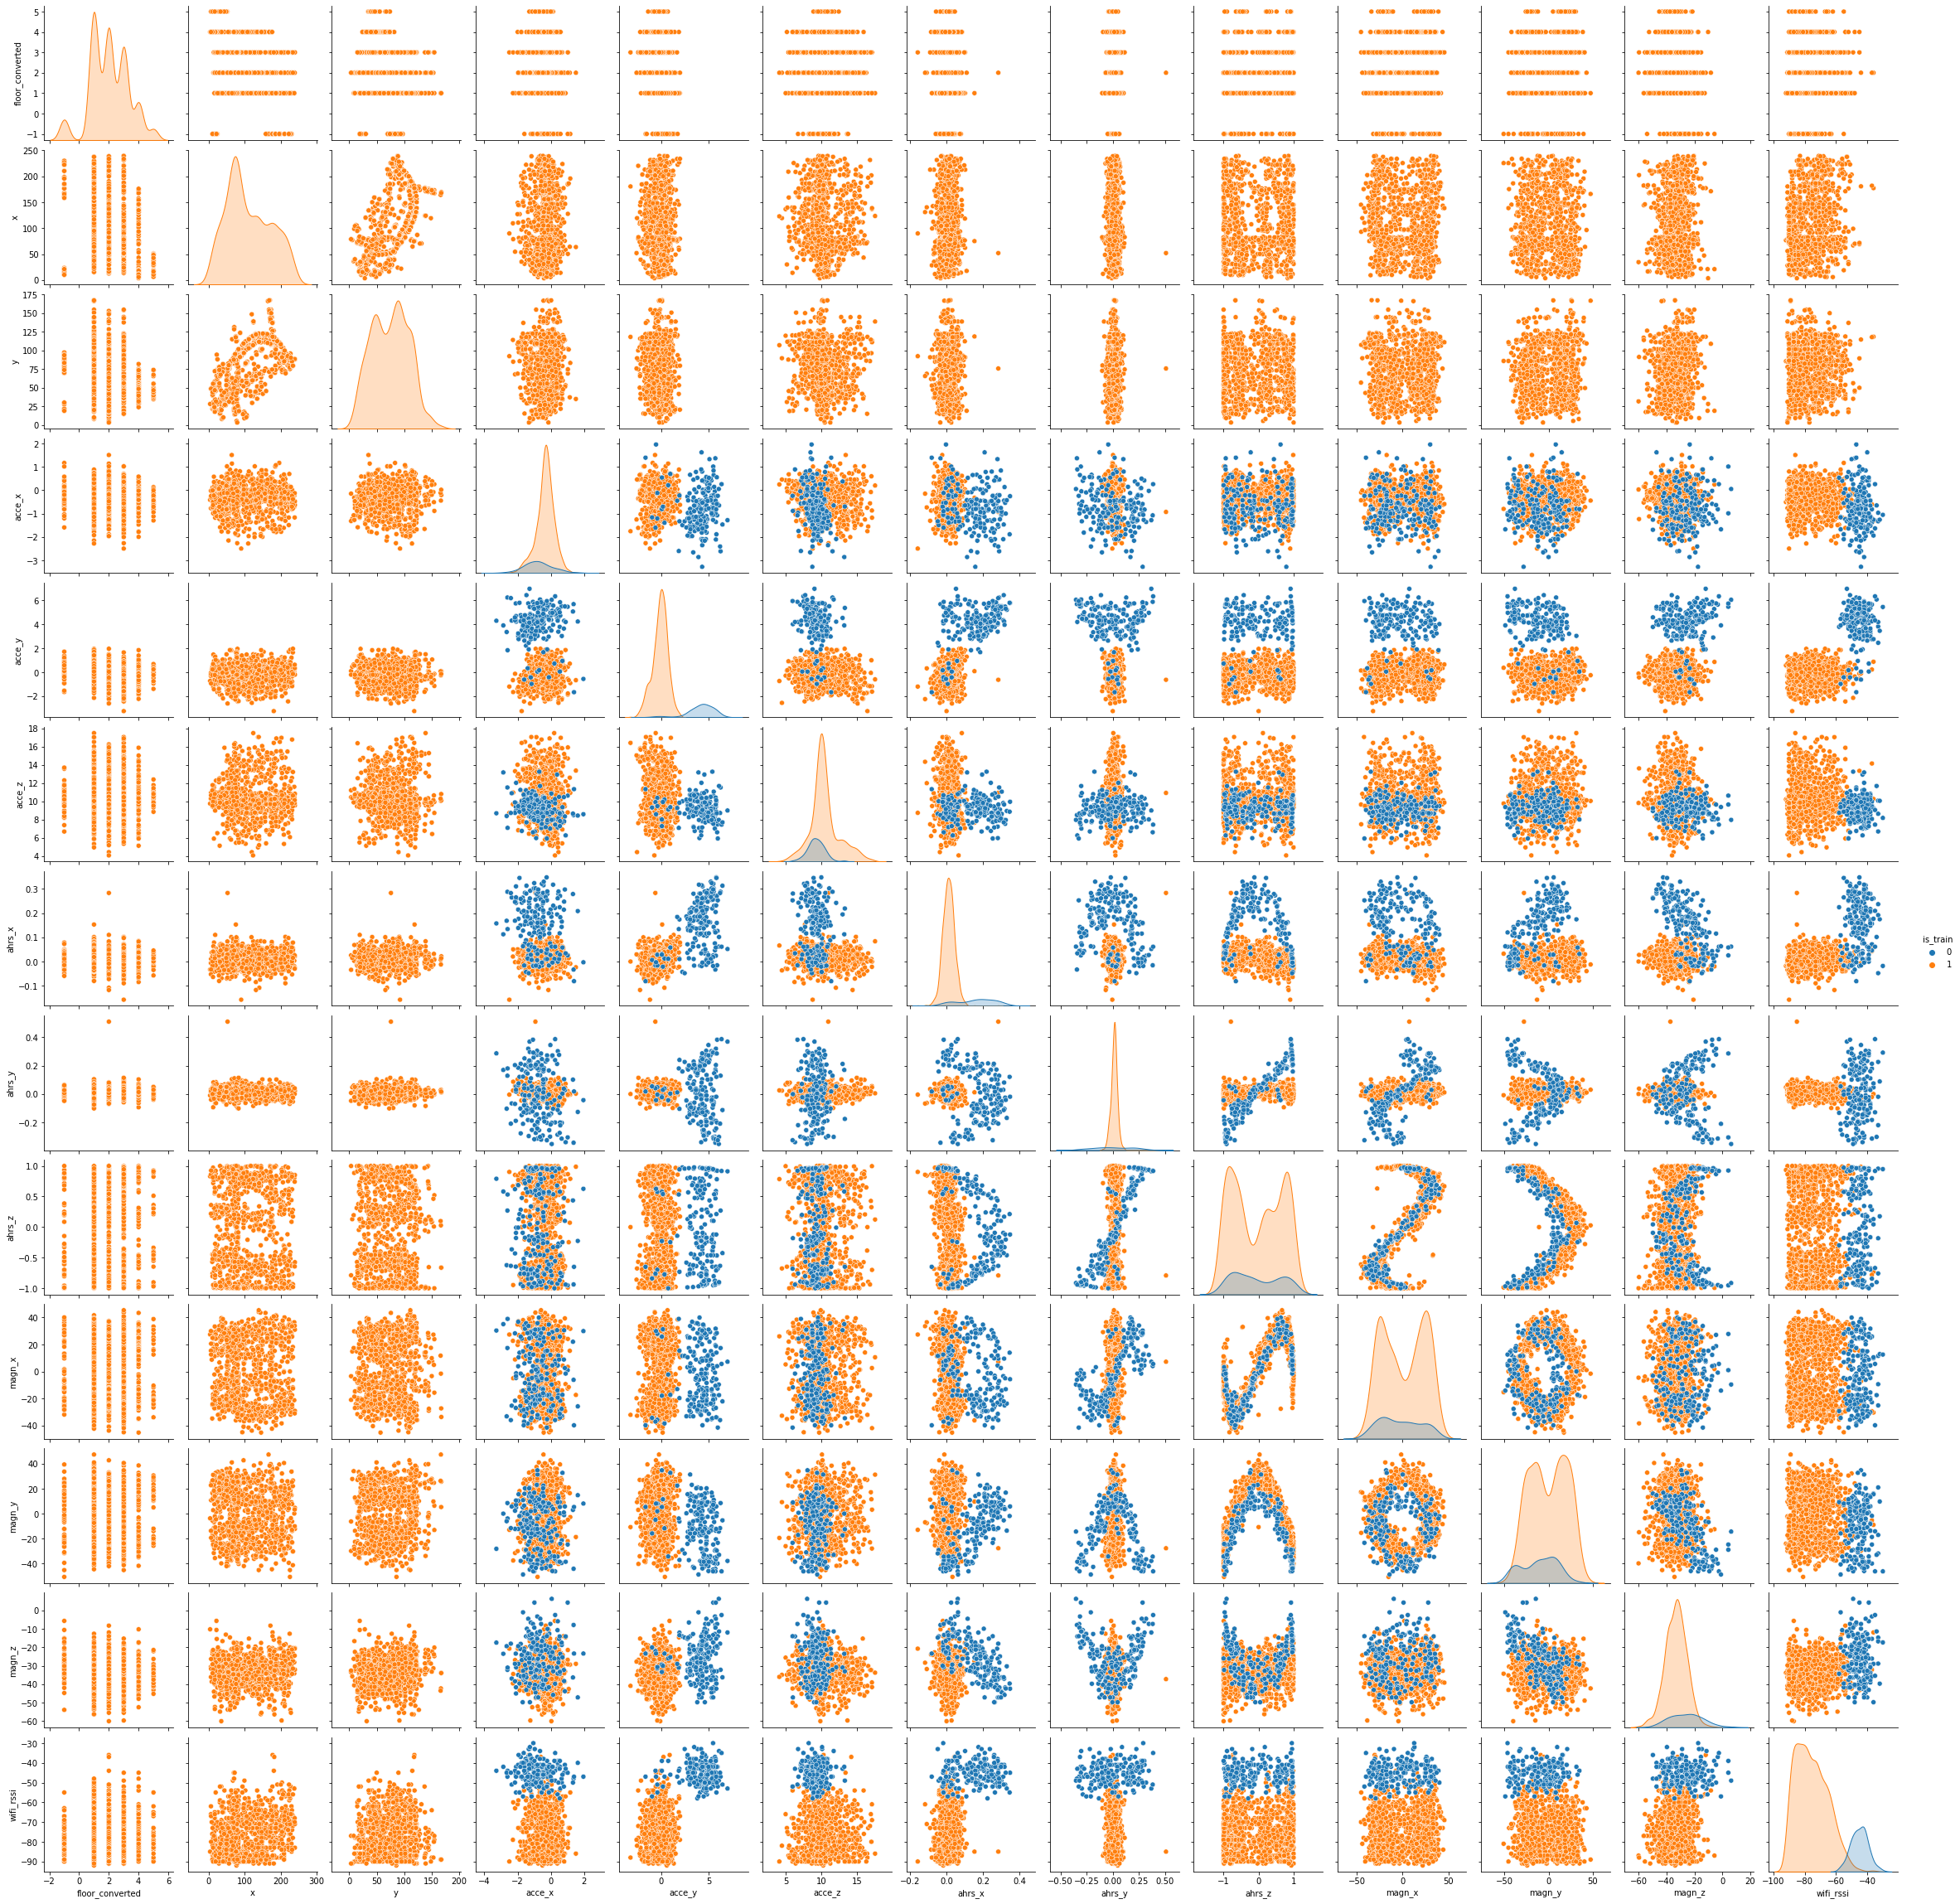

In [191]:
# compare train and test distribution
df_test["is_train"] = 0
df_train["is_train"] = 1
df_combine = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Narrow combined df down to numeric ones only
drop_non_num_cols = ["site_id", "file_id",  \
             "ts", "start_ts", "diff_start_ts", "acce_ts", "acce_acc", \
             "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
             "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
             "diff_wifi_last_ts", "diff_wifi_last_start_ts"
            ]

# pairplot of df
df_numeric = df_combine.drop(columns=drop_non_num_cols)
display(df_numeric.head())
sns.pairplot(df_numeric, hue='is_train')

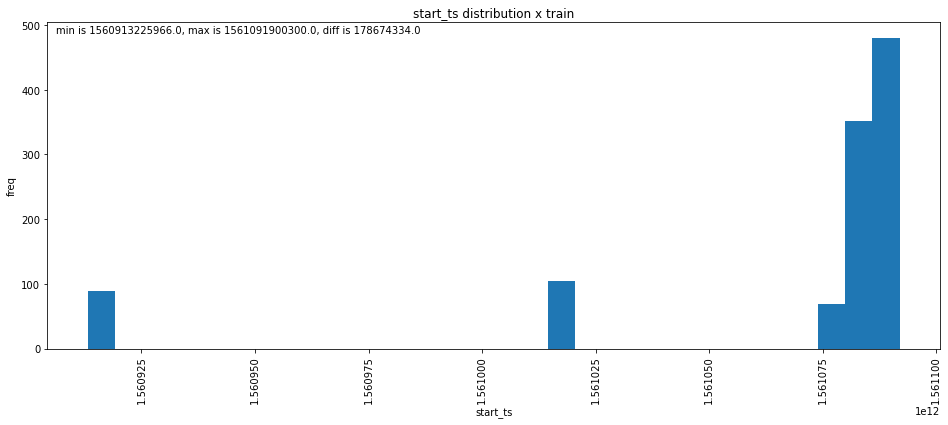

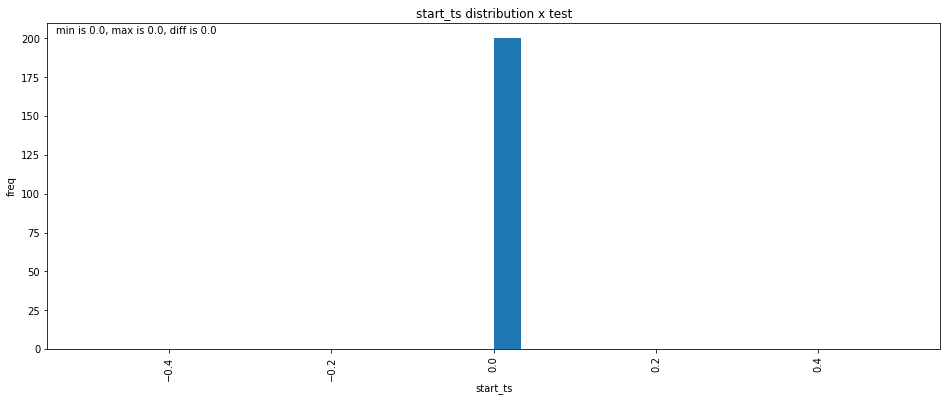

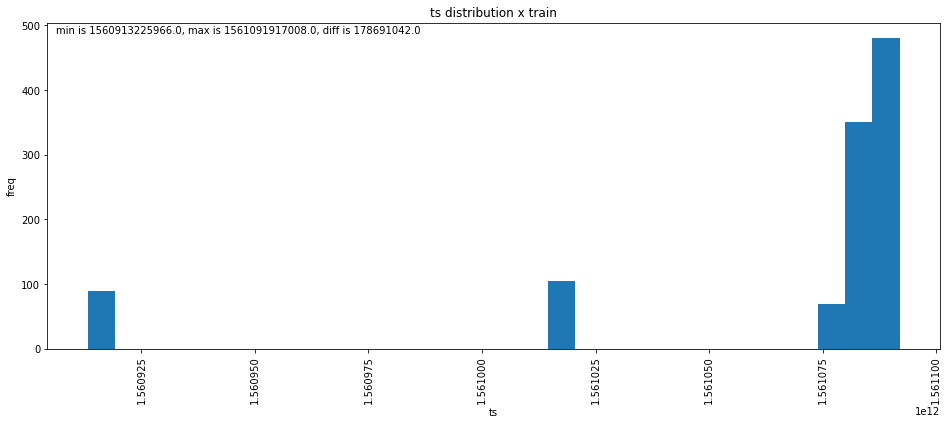

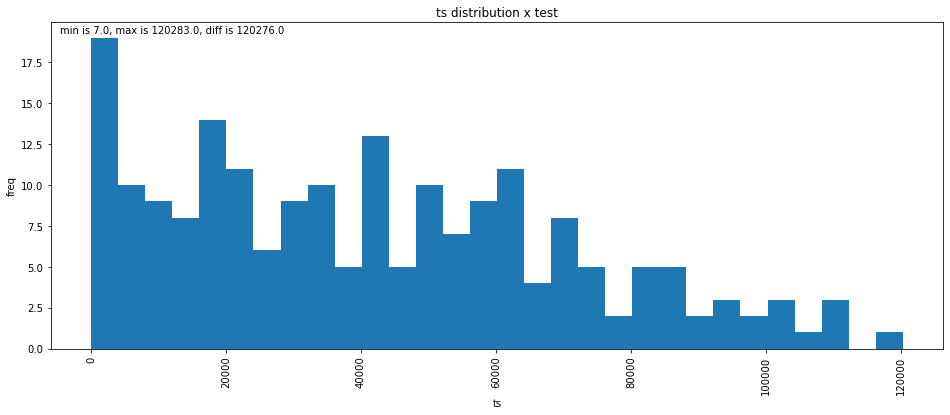

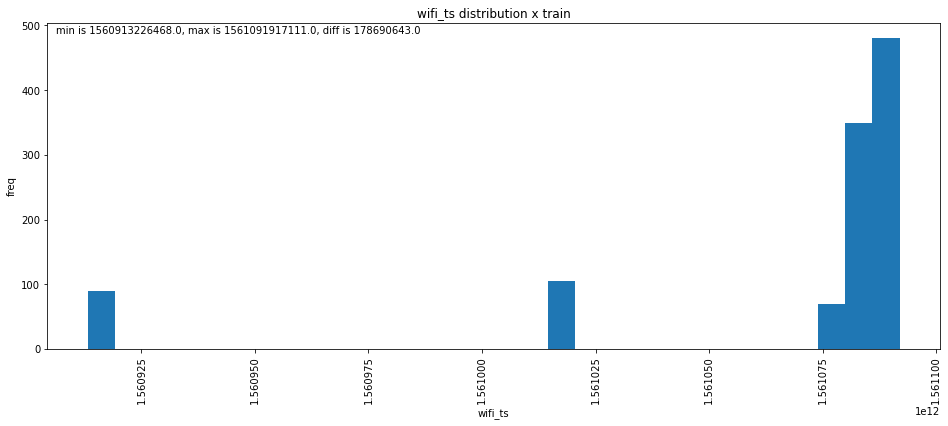

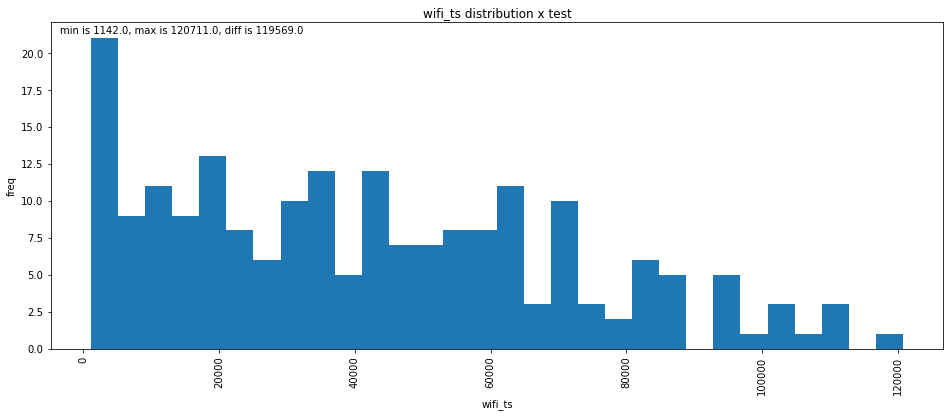

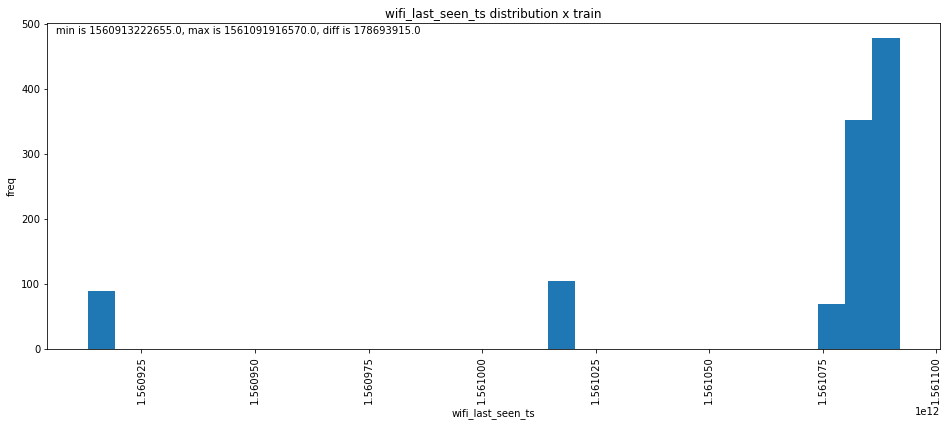

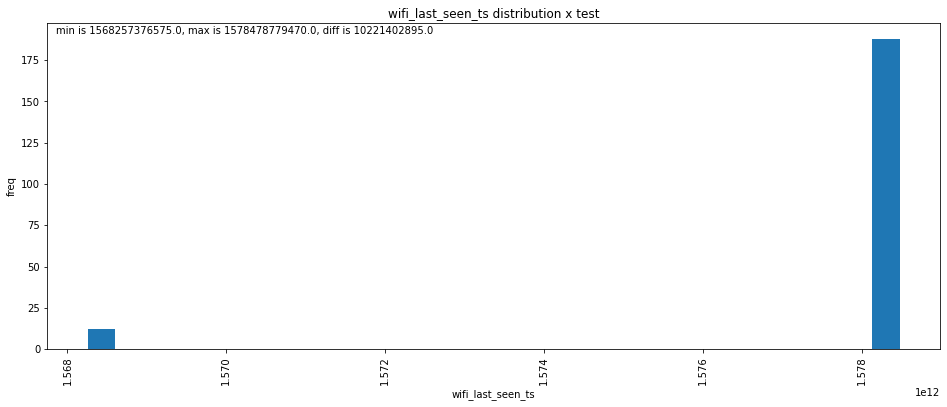

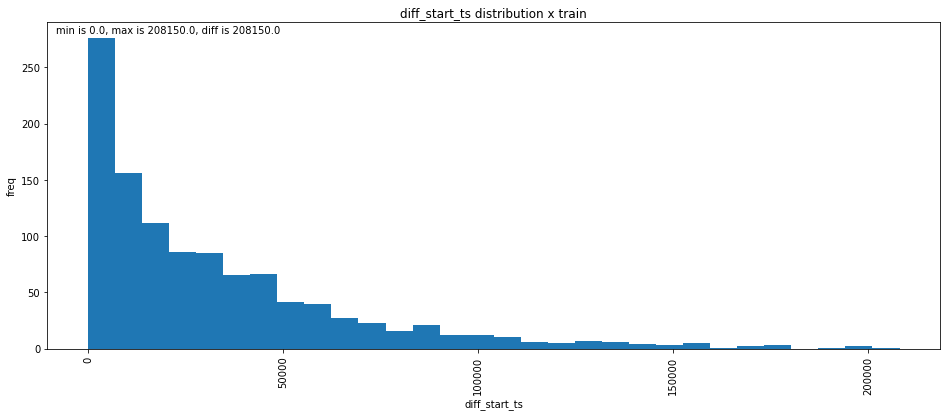

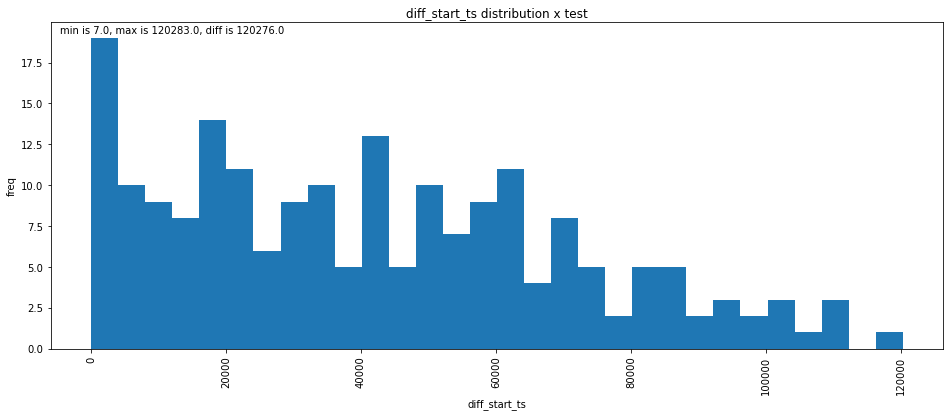

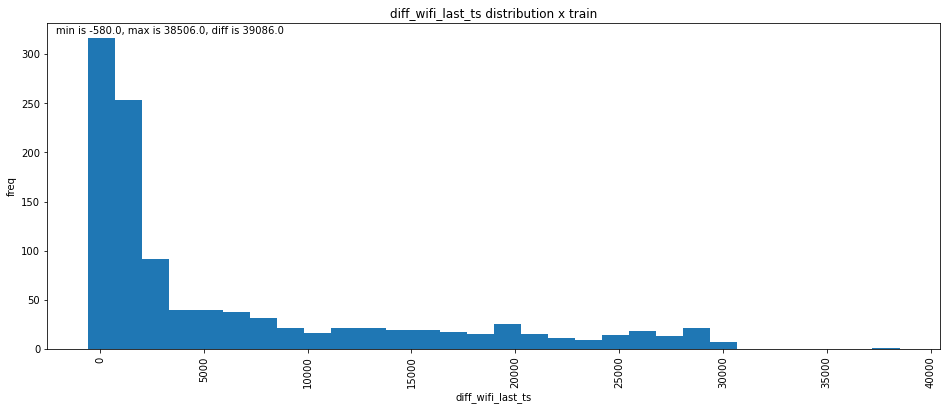

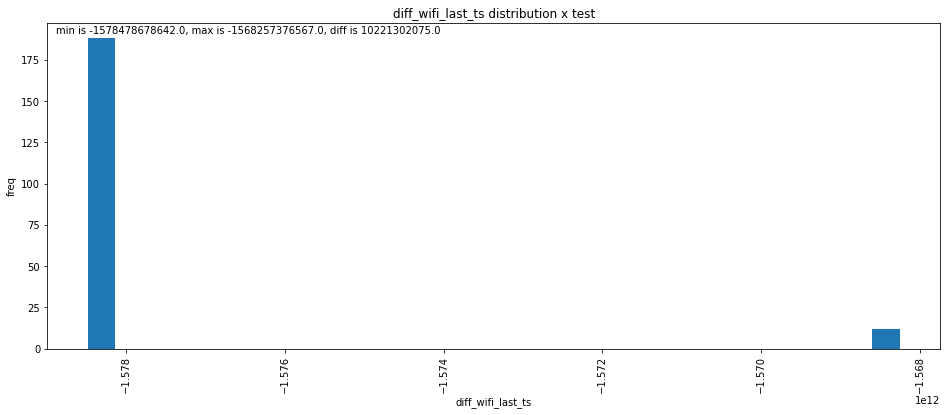

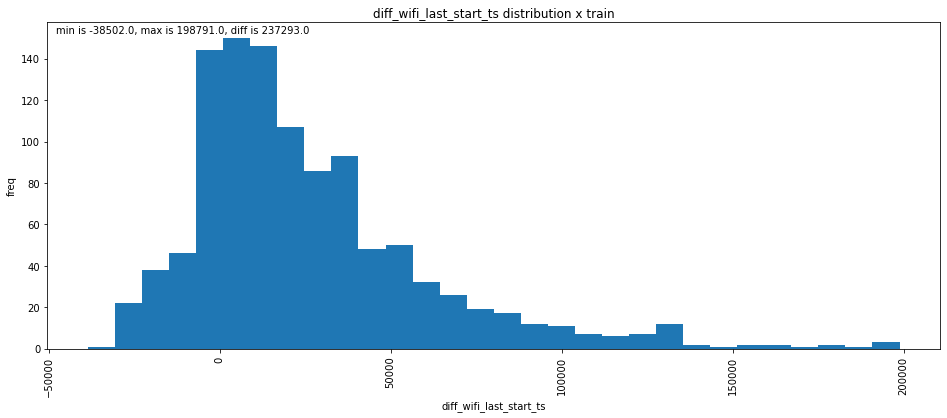

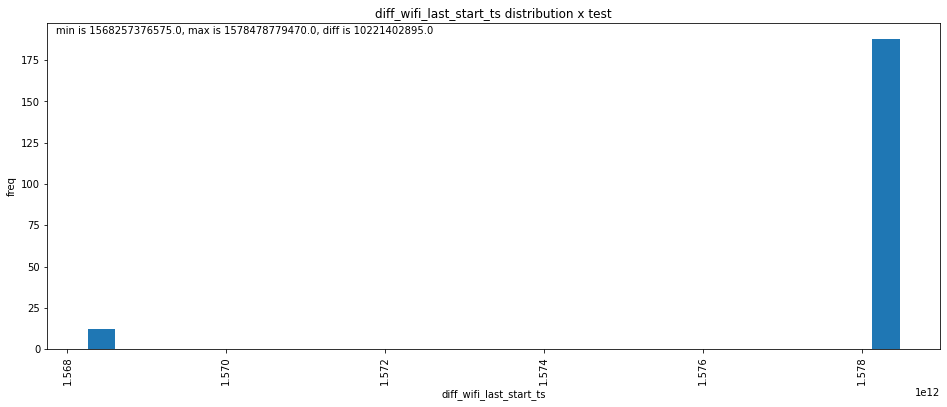

In [192]:
# bin and plot distribution : start_ts, ts, wifi_last_seen
# (don't plot them on the same scale)

# Add names to df
df_train.name = "df_train"
df_test.name = "df_test"

# how to annotate inside the graph -> to show min, max, diff
# https://analytics-note.xyz/programming/matplotlib-text-trans-axes/
def bin_plot(df, col, title, x_label, y_label):
    min_v = pd.to_numeric(df[col]).min()
    max_v = pd.to_numeric(df[col]).max()
    diff = max_v - min_v
    fig = plt.figure(figsize=(16.0, 6.0))
    ax = fig.add_subplot(1,1,1)
    ax.hist(df[col], bins=30)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.text(0.01, 0.99, "min is {}, max is {}, diff is {}".format(min_v, max_v, diff), verticalalignment='top', transform=ax.transAxes)
    rotation='vertical'
    ax.set_ylabel(y_label)
    plt.xticks(rotation=90)
    fig.show()

# ["start_ts", "ts", "wifi_ts", "wifi_last_seen_ts"] distribution x [df_train, df_test]
start = time.time() # just in case
cols = ["start_ts", "ts", "wifi_ts", "wifi_last_seen_ts", "diff_start_ts", \
        "diff_wifi_last_ts", "diff_wifi_last_start_ts"]

for col in cols:
    for df in [df_train, df_test]:
        df_title = "train" if df.name == "df_train" else "test"
        bin_plot(df, col, f"{col} distribution x {df_title}", f"{col}", "freq")

# print("time to process", time.time() - start)